In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in ".\bean-leaf-lesions-classification" (use force=True to force download)


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available:", device)

if device.type == "cuda":
    print("GPU in use:", torch.cuda.get_device_name())


Device available: cuda
GPU in use: NVIDIA GeForce RTX 3060


In [4]:
base_path = Path(os.getcwd()).resolve()

train_df = pd.read_csv(base_path/"bean-leaf-lesions-classification"/"train.csv")
val_df = pd.read_csv(base_path/"bean-leaf-lesions-classification"/"val.csv")

train_df.head()

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [5]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [6]:
print(train_df["category"].value_counts())

2    348
1    345
0    341
Name: category, dtype: int64


In [25]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df["category"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

train_dataset = CustomImageDataset(dataframe = train_df, transform=transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform=transform)

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir  # e.g., base_path / "bean-leaf-lesions-classification"
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"].values).to(device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        relative_path = self.dataframe.iloc[idx, 0]  # or use column name if available
        full_path = self.root_dir / relative_path

        image = Image.open(full_path).convert("RGB")
        if self.transform:
            image = self.transform(image).to(device)

        label = self.labels[idx]
        return image, label

img_dir = base_path / "bean-leaf-lesions-classification"

train_dataset = CustomImageDataset(dataframe=train_df, root_dir=img_dir, transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df, root_dir=img_dir, transform=transform)


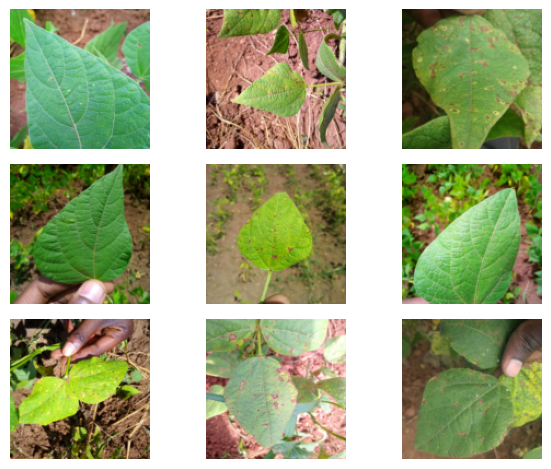

In [9]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image_tensor = train_dataset[np.random.randint(0, len(train_dataset))][0]
        image = image_tensor.permute(1, 2, 0).cpu().numpy()  # H x W x C

        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Hyperparameters

LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [11]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [12]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [13]:
for param in googlenet_model.parameters():
    param.requires_grad = True

In [14]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [15]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [16]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [17]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [18]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)}")

Epoch 1/15, Train Loss: 0.2081, Train Accuracy: 66.7311
Epoch 2/15, Train Loss: 0.1559, Train Accuracy: 75.6286
Epoch 3/15, Train Loss: 0.1334, Train Accuracy: 80.4642
Epoch 4/15, Train Loss: 0.1048, Train Accuracy: 85.3965
Epoch 5/15, Train Loss: 0.1089, Train Accuracy: 84.6228
Epoch 6/15, Train Loss: 0.0978, Train Accuracy: 85.9768
Epoch 7/15, Train Loss: 0.0528, Train Accuracy: 92.94
Epoch 8/15, Train Loss: 0.0722, Train Accuracy: 90.0387
Epoch 9/15, Train Loss: 0.0615, Train Accuracy: 91.3926
Epoch 10/15, Train Loss: 0.0595, Train Accuracy: 93.0368
Epoch 11/15, Train Loss: 0.0539, Train Accuracy: 92.7466
Epoch 12/15, Train Loss: 0.0467, Train Accuracy: 93.8104
Epoch 13/15, Train Loss: 0.0412, Train Accuracy: 94.6809
Epoch 14/15, Train Loss: 0.0406, Train Accuracy: 94.294
Epoch 15/15, Train Loss: 0.0296, Train Accuracy: 96.4217


In [19]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input, labels in val_loader:
        prediction = googlenet_model(input)

        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc

In [20]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

87.97


### Transfer Learning

In [21]:
googlenet_transfer = models.googlenet(weights='DEFAULT')

for param in googlenet_transfer.parameters():
    param.requires_grad = False

googlenet_transfer.fc = torch.nn.Linear(googlenet_transfer.fc.in_features, num_classes)
googlenet_transfer.fc.requires_grad = True
googlenet_transfer.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_transfer.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_transfer(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)}")

Epoch 1/15, Train Loss: 0.2385, Train Accuracy: 55.1257
Epoch 2/15, Train Loss: 0.1976, Train Accuracy: 64.9903
Epoch 3/15, Train Loss: 0.1877, Train Accuracy: 69.8259
Epoch 4/15, Train Loss: 0.1766, Train Accuracy: 70.793
Epoch 5/15, Train Loss: 0.1829, Train Accuracy: 67.9884
Epoch 6/15, Train Loss: 0.1694, Train Accuracy: 72.3404
Epoch 7/15, Train Loss: 0.1692, Train Accuracy: 70.9865
Epoch 8/15, Train Loss: 0.1703, Train Accuracy: 71.5667
Epoch 9/15, Train Loss: 0.1622, Train Accuracy: 74.6615
Epoch 10/15, Train Loss: 0.1668, Train Accuracy: 72.9207
Epoch 11/15, Train Loss: 0.1651, Train Accuracy: 74.0812
Epoch 12/15, Train Loss: 0.1695, Train Accuracy: 73.3075
Epoch 13/15, Train Loss: 0.1747, Train Accuracy: 71.9536
Epoch 14/15, Train Loss: 0.1702, Train Accuracy: 72.0503
Epoch 15/15, Train Loss: 0.1784, Train Accuracy: 70.0193


In [23]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input, labels in val_loader:
        prediction = googlenet_transfer(input)

        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc

print(round(total_acc_test/val_dataset.__len__()*100,2))

75.19


In [26]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    googlenet_model.eval()

    with torch.no_grad():
        output = googlenet_model(image.unsqueeze(0))

    output = torch.argmax(output, axis=1).item()
    return label_encoder.inverse_transform([output])

In [27]:
predict_image("bean_rust_sample.jpg").item()

2